C:\Users\Dell\AppData\Local\Temp\ipykernel_17048\4124832483.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


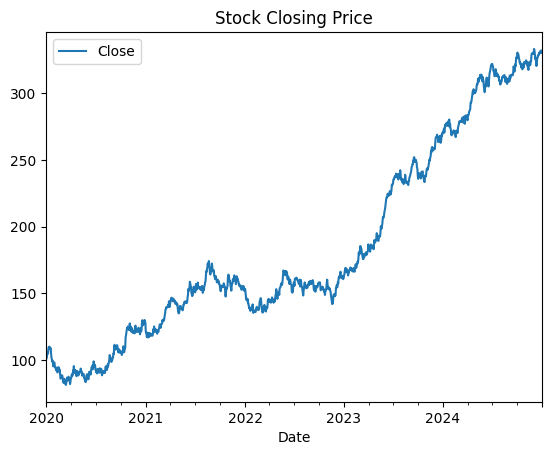

ADF Statistic: 0.9283656668213802
p-value: 0.993449561958063


In [3]:
# 📊 Data Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Load data
df = pd.read_csv('stock_data.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]
df = df.asfreq('B')
df = df.fillna(method='ffill')

# Plot
df.plot(title="Stock Closing Price")
plt.show()

# Stationarity Check
result = adfuller(df['Close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

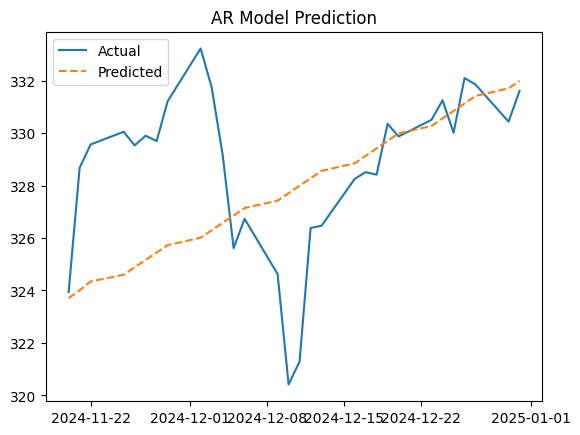

In [3]:
# 1️⃣ AR Model
from statsmodels.tsa.ar_model import AutoReg

train, test = df['Close'][:-30], df['Close'][-30:]

model = AutoReg(train, lags=5).fit()
preds = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, preds.values, label='Predicted', linestyle='--')
plt.legend()
plt.title("AR Model Prediction")
plt.show()

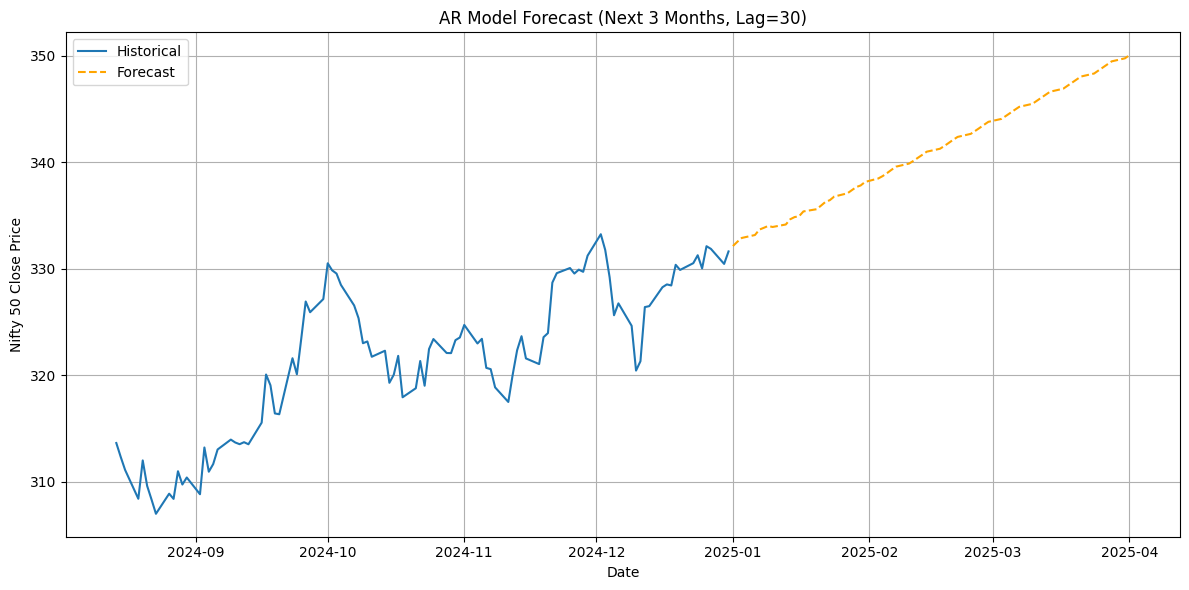

In [4]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Split full data for training
train = df['Close']

# Fit AR model with grid search for best lag
best_aic = float('inf')
best_lag = 0
for lag in range(1, 31):
    try:
        model = AutoReg(train, lags=lag).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_lag = lag
    except:
        continue

# Train final model on best lag
model = AutoReg(train, lags=best_lag).fit()

# Forecast next 65 business days (~3 months)
forecast_steps = 65
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast = model.predict(start=len(train), end=len(train) + forecast_steps - 1, dynamic=False)
forecast.index = forecast_index

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['Close'].tail(100), label='Historical')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--', color='orange')
plt.title(f"AR Model Forecast (Next 3 Months, Lag={best_lag})")
plt.xlabel("Date")
plt.ylabel("Nifty 50 Close Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# 2️⃣ ARIMA with Grid Search
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools

warnings.filterwarnings("ignore")

p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
best_score, best_cfg = float("inf"), None

for param in pdq:
    try:
        model = ARIMA(train, order=param)
        results = model.fit()
        preds = results.predict(start=len(train), end=len(train)+len(test)-1)
        mse = mean_squared_error(test, preds)
        if mse < best_score:
            best_score, best_cfg = mse, param
        print(f'ARIMA{param} MSE={mse:.3f}')
    except:
        continue

print(f'Best ARIMA{best_cfg} MSE={best_score:.3f}')

ARIMA(0, 0, 0) MSE=21887.916
ARIMA(0, 0, 1) MSE=21365.836
ARIMA(0, 0, 2) MSE=20975.775
ARIMA(0, 0, 3) MSE=20504.896
ARIMA(0, 1, 0) MSE=35.839
ARIMA(0, 1, 1) MSE=36.335
ARIMA(0, 1, 2) MSE=36.077
ARIMA(0, 1, 3) MSE=36.214
ARIMA(0, 2, 0) MSE=1614.043
ARIMA(0, 2, 1) MSE=13.027
ARIMA(0, 2, 2) MSE=13.150
ARIMA(0, 2, 3) MSE=13.144
ARIMA(0, 3, 0) MSE=499444.397
ARIMA(0, 3, 1) MSE=1650.419
ARIMA(0, 3, 2) MSE=24.325
ARIMA(0, 3, 3) MSE=31.170
ARIMA(1, 0, 0) MSE=40.049
ARIMA(1, 0, 1) MSE=40.398
ARIMA(1, 0, 2) MSE=40.239
ARIMA(1, 0, 3) MSE=40.622
ARIMA(1, 1, 0) MSE=36.341
ARIMA(1, 1, 1) MSE=36.297
ARIMA(1, 1, 2) MSE=15.095
ARIMA(1, 1, 3) MSE=35.952
ARIMA(1, 2, 0) MSE=463.909
ARIMA(1, 2, 1) MSE=13.152
ARIMA(1, 2, 2) MSE=13.035
ARIMA(1, 2, 3) MSE=13.140
ARIMA(1, 3, 0) MSE=325086.401
ARIMA(1, 3, 1) MSE=472.982
ARIMA(1, 3, 2) MSE=24.984
ARIMA(1, 3, 3) MSE=13.377
ARIMA(2, 0, 0) MSE=40.460
ARIMA(2, 0, 1) MSE=40.055
ARIMA(2, 0, 2) MSE=40.616
ARIMA(2, 0, 3) MSE=40.381
ARIMA(2, 1, 0) MSE=36.076
ARIMA(2, 1, 

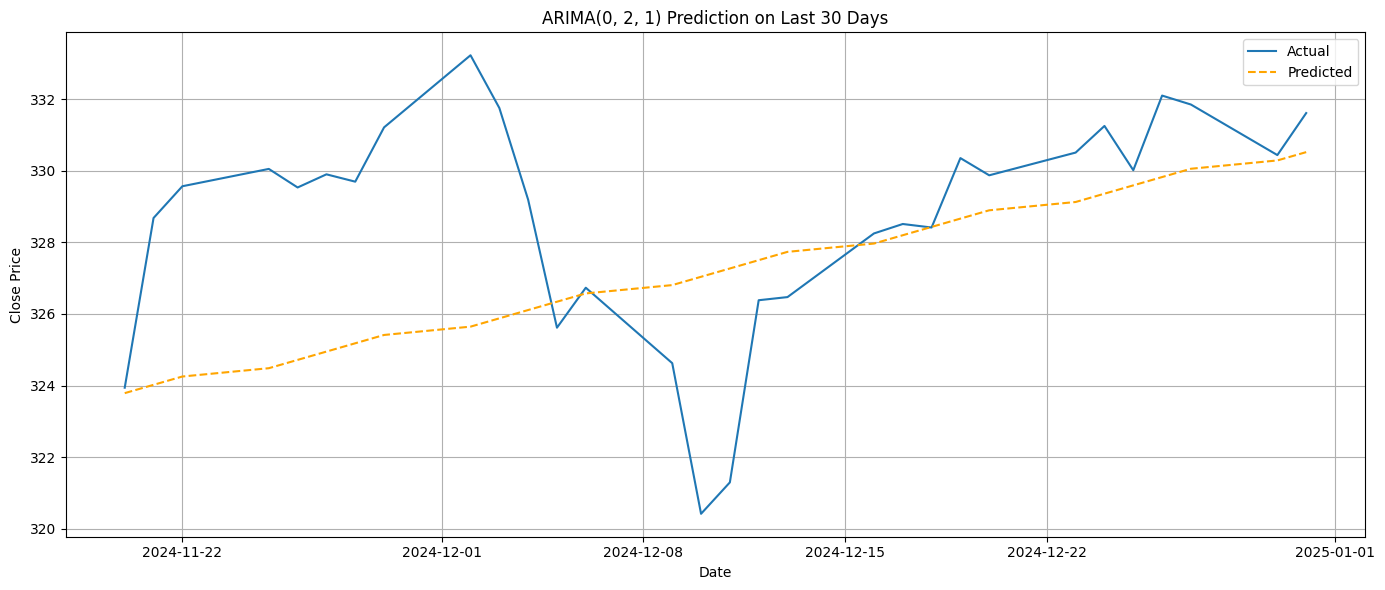

In [6]:
# Fit best model and predict test set
final_model = ARIMA(train, order=best_cfg).fit()
preds = final_model.predict(start=len(train), end=len(train)+len(test)-1)

# Plot prediction vs actual
plt.figure(figsize=(14, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, preds, label='Predicted', linestyle='--', color='orange')
plt.title(f"ARIMA{best_cfg} Prediction on Last 30 Days")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

🔍 Grid Search using MSE on last 30 days...

ARIMA(0, 0, 0) MSE = 21887.92
ARIMA(0, 0, 1) MSE = 21365.84
ARIMA(0, 0, 2) MSE = 20975.78
ARIMA(0, 0, 3) MSE = 20504.90
ARIMA(0, 1, 0) MSE = 35.84
ARIMA(0, 1, 1) MSE = 36.33
ARIMA(0, 1, 2) MSE = 36.08
ARIMA(0, 1, 3) MSE = 36.21
ARIMA(0, 2, 0) MSE = 1614.04
ARIMA(0, 2, 1) MSE = 13.03
ARIMA(0, 2, 2) MSE = 13.15
ARIMA(0, 2, 3) MSE = 13.14
ARIMA(0, 3, 0) MSE = 499444.40
ARIMA(0, 3, 1) MSE = 1650.42
ARIMA(0, 3, 2) MSE = 24.33
ARIMA(0, 3, 3) MSE = 31.17
ARIMA(1, 0, 0) MSE = 40.05
ARIMA(1, 0, 1) MSE = 40.40
ARIMA(1, 0, 2) MSE = 40.24
ARIMA(1, 0, 3) MSE = 40.62
ARIMA(1, 1, 0) MSE = 36.34
ARIMA(1, 1, 1) MSE = 36.30
ARIMA(1, 1, 2) MSE = 15.10
ARIMA(1, 1, 3) MSE = 35.95
ARIMA(1, 2, 0) MSE = 463.91
ARIMA(1, 2, 1) MSE = 13.15
ARIMA(1, 2, 2) MSE = 13.04
ARIMA(1, 2, 3) MSE = 13.14
ARIMA(1, 3, 0) MSE = 325086.40
ARIMA(1, 3, 1) MSE = 472.98
ARIMA(1, 3, 2) MSE = 24.98
ARIMA(1, 3, 3) MSE = 13.38
ARIMA(2, 0, 0) MSE = 40.46
ARIMA(2, 0, 1) MSE = 40.06
ARIMA(2, 0, 

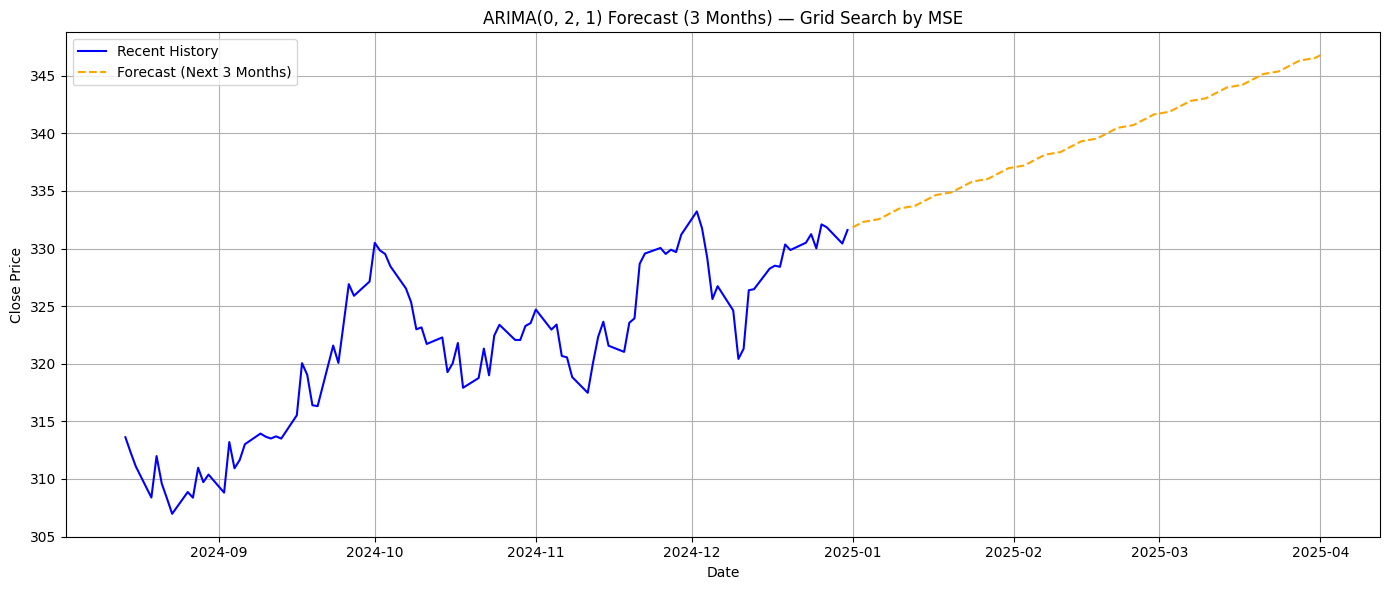

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
import itertools

warnings.filterwarnings("ignore")

# Step 1: Train/test split
train = df['Close'][:-30]
test = df['Close'][-30:]

# Step 2: Grid Search for best (p,d,q) using MSE
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_score = float('inf')
best_order = None

print("🔍 Grid Search using MSE on last 30 days...\n")
for param in pdq:
    try:
        model = ARIMA(train, order=param)
        results = model.fit()
        preds = results.predict(start=len(train), end=len(train)+len(test)-1)
        mse = mean_squared_error(test, preds)
        print(f"ARIMA{param} MSE = {mse:.2f}")
        if mse < best_score:
            best_score = mse
            best_order = param
    except:
        continue

print(f"\n✅ Best ARIMA order by MSE: {best_order} with MSE: {best_score:.2f}")

# Step 3: Fit final model on full data
final_model = ARIMA(df['Close'], order=best_order)
results = final_model.fit()

# Step 4: Forecast next 65 business days (~3 months)
forecast_steps = 65
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast = results.forecast(steps=forecast_steps)
forecast.index = future_dates

# Step 5: Plot results
plt.figure(figsize=(14, 6))
plt.plot(df.index[-100:], df['Close'].tail(100), label='Recent History', color='blue')
plt.plot(forecast.index, forecast, label='Forecast (Next 3 Months)', linestyle='--', color='orange')
plt.title(f"ARIMA{best_order} Forecast (3 Months) — Grid Search by MSE")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# 3️⃣ SARIMA with Grid Search
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = [5, 7, 12]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
best_score, best_params = float("inf"), None

for param in pdq:
    for seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()
            preds = results.predict(start=len(train), end=len(train)+len(test)-1)
            mse = mean_squared_error(test, preds)
            if mse < best_score:
                best_score = mse
                best_params = (param, seasonal)
            print(f"SARIMA{param}x{seasonal} - MSE={mse:.3f}")
        except:
            continue

print(f"Best SARIMA: {best_params} with MSE: {best_score:.3f}")

SARIMA(0, 0, 0)x(0, 0, 0, 5) - MSE=108061.731
SARIMA(0, 0, 0)x(0, 0, 0, 7) - MSE=108061.731
SARIMA(0, 0, 0)x(0, 0, 0, 12) - MSE=108061.731
SARIMA(0, 0, 0)x(0, 0, 1, 5) - MSE=94592.112
SARIMA(0, 0, 0)x(0, 0, 1, 7) - MSE=89450.416
SARIMA(0, 0, 0)x(0, 0, 1, 12) - MSE=76249.086
SARIMA(0, 0, 0)x(0, 1, 0, 5) - MSE=50.358
SARIMA(0, 0, 0)x(0, 1, 0, 7) - MSE=67.710
SARIMA(0, 0, 0)x(0, 1, 0, 12) - MSE=69.832
SARIMA(0, 0, 0)x(0, 1, 1, 5) - MSE=49.043
SARIMA(0, 0, 0)x(0, 1, 1, 7) - MSE=69.438
SARIMA(0, 0, 0)x(0, 1, 1, 12) - MSE=70.562
SARIMA(0, 0, 0)x(1, 0, 0, 5) - MSE=15.560
SARIMA(0, 0, 0)x(1, 0, 0, 7) - MSE=17.215
SARIMA(0, 0, 0)x(1, 0, 0, 12) - MSE=19.052
SARIMA(0, 0, 0)x(1, 0, 1, 5) - MSE=15.580
SARIMA(0, 0, 0)x(1, 0, 1, 7) - MSE=17.487
SARIMA(0, 0, 0)x(1, 0, 1, 12) - MSE=19.071
SARIMA(0, 0, 0)x(1, 1, 0, 5) - MSE=48.853
SARIMA(0, 0, 0)x(1, 1, 0, 7) - MSE=69.654
SARIMA(0, 0, 0)x(1, 1, 0, 12) - MSE=71.300
SARIMA(0, 0, 0)x(1, 1, 1, 5) - MSE=48.839
SARIMA(0, 0, 0)x(1, 1, 1, 7) - MSE=68.744
SARIMA

SARIMA(0, 2, 1)x(1, 1, 1, 12) - MSE=13.846
SARIMA(0, 2, 2)x(0, 0, 0, 5) - MSE=13.157
SARIMA(0, 2, 2)x(0, 0, 0, 7) - MSE=13.157
SARIMA(0, 2, 2)x(0, 0, 0, 12) - MSE=13.157
SARIMA(0, 2, 2)x(0, 0, 1, 5) - MSE=13.047
SARIMA(0, 2, 2)x(0, 0, 1, 7) - MSE=12.957
SARIMA(0, 2, 2)x(0, 0, 1, 12) - MSE=13.407
SARIMA(0, 2, 2)x(0, 1, 0, 5) - MSE=75.643
SARIMA(0, 2, 2)x(0, 1, 0, 7) - MSE=57.815
SARIMA(0, 2, 2)x(0, 1, 0, 12) - MSE=111.988
SARIMA(0, 2, 2)x(0, 1, 1, 5) - MSE=13.558
SARIMA(0, 2, 2)x(0, 1, 1, 7) - MSE=13.591
SARIMA(0, 2, 2)x(0, 1, 1, 12) - MSE=13.719
SARIMA(0, 2, 2)x(1, 0, 0, 5) - MSE=13.091
SARIMA(0, 2, 2)x(1, 0, 0, 7) - MSE=13.043
SARIMA(0, 2, 2)x(1, 0, 0, 12) - MSE=13.047
SARIMA(0, 2, 2)x(1, 0, 1, 5) - MSE=13.051
SARIMA(0, 2, 2)x(1, 0, 1, 7) - MSE=12.997
SARIMA(0, 2, 2)x(1, 0, 1, 12) - MSE=13.269
SARIMA(0, 2, 2)x(1, 1, 0, 5) - MSE=21.617
SARIMA(0, 2, 2)x(1, 1, 0, 7) - MSE=15.315
SARIMA(0, 2, 2)x(1, 1, 0, 12) - MSE=41.789
SARIMA(0, 2, 2)x(1, 1, 1, 5) - MSE=13.622
SARIMA(0, 2, 2)x(1, 1, 1,

SARIMA(1, 2, 1)x(0, 0, 0, 5) - MSE=13.161
SARIMA(1, 2, 1)x(0, 0, 0, 7) - MSE=13.161
SARIMA(1, 2, 1)x(0, 0, 0, 12) - MSE=13.161
SARIMA(1, 2, 1)x(0, 0, 1, 5) - MSE=13.086
SARIMA(1, 2, 1)x(0, 0, 1, 7) - MSE=12.948
SARIMA(1, 2, 1)x(0, 0, 1, 12) - MSE=13.323
SARIMA(1, 2, 1)x(0, 1, 0, 5) - MSE=75.680
SARIMA(1, 2, 1)x(0, 1, 0, 7) - MSE=57.785
SARIMA(1, 2, 1)x(0, 1, 0, 12) - MSE=111.953
SARIMA(1, 2, 1)x(0, 1, 1, 5) - MSE=13.555
SARIMA(1, 2, 1)x(0, 1, 1, 7) - MSE=13.588
SARIMA(1, 2, 1)x(0, 1, 1, 12) - MSE=13.716
SARIMA(1, 2, 1)x(1, 0, 0, 5) - MSE=13.099
SARIMA(1, 2, 1)x(1, 0, 0, 7) - MSE=13.035
SARIMA(1, 2, 1)x(1, 0, 0, 12) - MSE=13.062
SARIMA(1, 2, 1)x(1, 0, 1, 5) - MSE=13.122
SARIMA(1, 2, 1)x(1, 0, 1, 7) - MSE=12.841
SARIMA(1, 2, 1)x(1, 0, 1, 12) - MSE=13.448
SARIMA(1, 2, 1)x(1, 1, 0, 5) - MSE=21.596
SARIMA(1, 2, 1)x(1, 1, 0, 7) - MSE=15.306
SARIMA(1, 2, 1)x(1, 1, 0, 12) - MSE=41.732
SARIMA(1, 2, 1)x(1, 1, 1, 5) - MSE=13.625
SARIMA(1, 2, 1)x(1, 1, 1, 7) - MSE=13.795
SARIMA(1, 2, 1)x(1, 1, 1, 

SARIMA(2, 2, 0)x(0, 0, 1, 5) - MSE=61.419
SARIMA(2, 2, 0)x(0, 0, 1, 7) - MSE=67.157
SARIMA(2, 2, 0)x(0, 0, 1, 12) - MSE=59.442
SARIMA(2, 2, 0)x(0, 1, 0, 5) - MSE=323.925
SARIMA(2, 2, 0)x(0, 1, 0, 7) - MSE=7350.307
SARIMA(2, 2, 0)x(0, 1, 0, 12) - MSE=268.574
SARIMA(2, 2, 0)x(0, 1, 1, 5) - MSE=30.716
SARIMA(2, 2, 0)x(0, 1, 1, 7) - MSE=35.572
SARIMA(2, 2, 0)x(0, 1, 1, 12) - MSE=86.573
SARIMA(2, 2, 0)x(1, 0, 0, 5) - MSE=61.778
SARIMA(2, 2, 0)x(1, 0, 0, 7) - MSE=66.145
SARIMA(2, 2, 0)x(1, 0, 0, 12) - MSE=60.104
SARIMA(2, 2, 0)x(1, 0, 1, 5) - MSE=62.207
SARIMA(2, 2, 0)x(1, 0, 1, 7) - MSE=63.173
SARIMA(2, 2, 0)x(1, 0, 1, 12) - MSE=59.862
SARIMA(2, 2, 0)x(1, 1, 0, 5) - MSE=349.870
SARIMA(2, 2, 0)x(1, 1, 0, 7) - MSE=1230.390
SARIMA(2, 2, 0)x(1, 1, 0, 12) - MSE=54.024
SARIMA(2, 2, 0)x(1, 1, 1, 5) - MSE=31.023
SARIMA(2, 2, 0)x(1, 1, 1, 7) - MSE=35.395
SARIMA(2, 2, 0)x(1, 1, 1, 12) - MSE=86.478
SARIMA(2, 2, 1)x(0, 0, 0, 5) - MSE=13.130
SARIMA(2, 2, 1)x(0, 0, 0, 7) - MSE=13.130
SARIMA(2, 2, 1)x(0, 

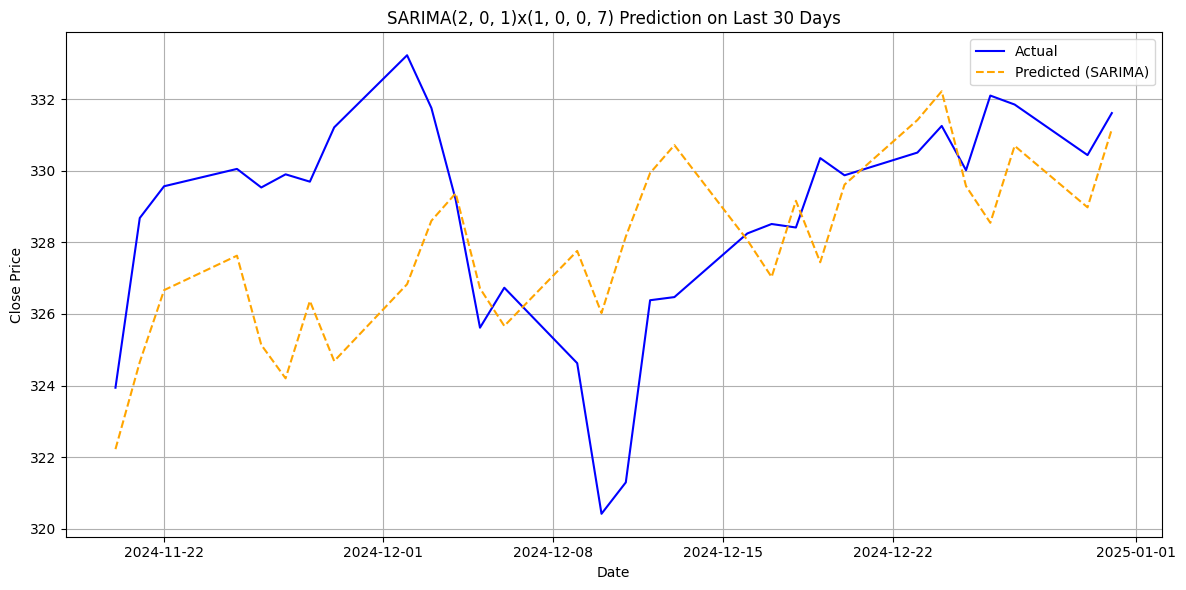

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Use your saved best parameters
order = (2, 0, 1)
seasonal_order = (1, 0, 0, 7)

# Split again to confirm alignment
train = df['Close'][:-30]
test = df['Close'][-30:]

# Fit SARIMA on training set
model = SARIMAX(train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

# Predict on test range
preds = results.predict(start=len(train), end=len(train)+len(test)-1)
preds.index = test.index

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual', color='blue')
plt.plot(preds.index, preds.values, label='Predicted (SARIMA)', linestyle='--', color='orange')
plt.title(f"SARIMA{order}x{seasonal_order} Prediction on Last 30 Days")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/10


D:\anconda\envs\notebook-6.5.7\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0406
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.4566e-04
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.6513e-04
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.3189e-04
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.6082e-04
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.3137e-04
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.7344e-04
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.1489e-04
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.3635e-04
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.0191e-04


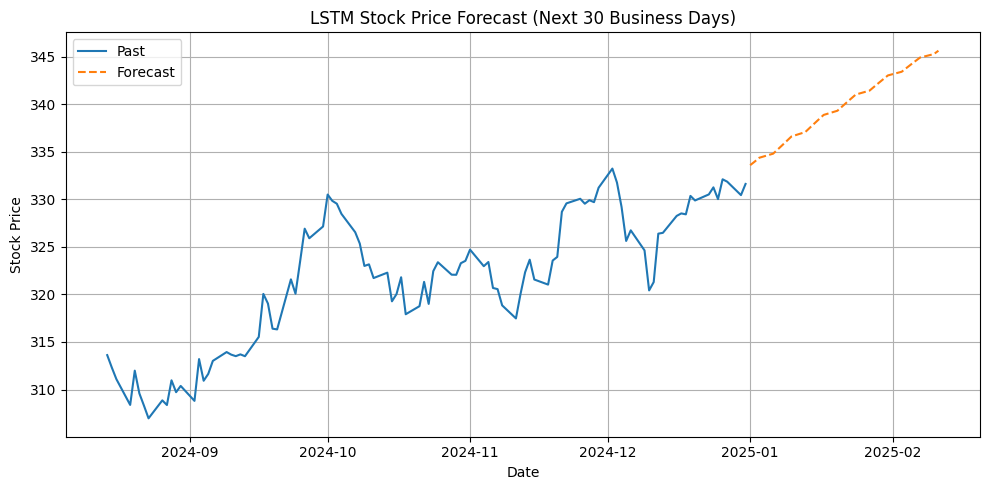

In [5]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']].values)

# 2️⃣ Create sequences for LSTM
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window = 60
X, y = create_sequences(scaled_data, window)

# 3️⃣ Split the data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 4️⃣ Define and train the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# 5️⃣ Forecast future values (next 30 days)
forecast_steps = 30
forecast_input = scaled_data[-window:]  # Last 60 values
forecast = []

for _ in range(forecast_steps):
    input_seq = forecast_input[-window:].reshape(1, window, 1)
    next_pred = model.predict(input_seq, verbose=0)
    forecast.append(next_pred[0, 0])
    forecast_input = np.append(forecast_input, next_pred)[-window:]

# 6️⃣ Inverse scale predictions
forecast = np.array(forecast).reshape(-1, 1)
forecast_inv = scaler.inverse_transform(forecast)

# 7️⃣ Plot
plt.figure(figsize=(10, 5))
plt.plot(df.index[-100:], df['Close'].values[-100:], label='Past')
future_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='B')[1:]
plt.plot(future_dates, forecast_inv, label='Forecast', linestyle='--')
plt.title("LSTM Stock Price Forecast (Next 30 Business Days)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/10


D:\anconda\envs\notebook-6.5.7\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0421
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 9.3724e-04
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.9618e-04
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.8858e-04
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.7355e-04
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.7761e-04
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.5994e-04
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.3100e-04
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.2839e-04
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.3510e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


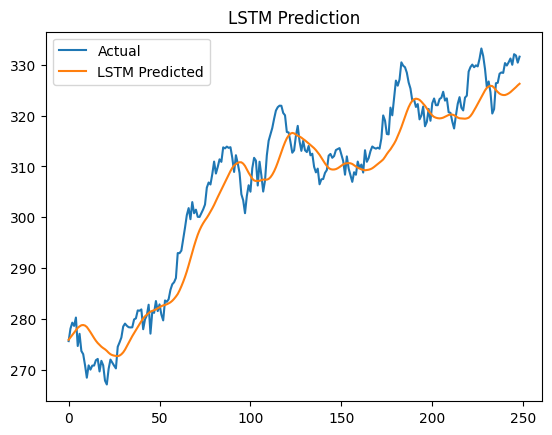

In [7]:
# 4️⃣ LSTM Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window = 60
X, y = create_sequences(scaled_data, window)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)
y_test = scaler.inverse_transform(y_test)

plt.plot(y_test, label='Actual')
plt.plot(preds, label='LSTM Predicted')
plt.legend()
plt.title("LSTM Prediction")
plt.show()

In [12]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached cython-3.1.1-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12.tar.gz (5.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached ephem-4.2-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached aiohttp-3.12.8-cp311-cp311-win_amd64.whl.metadata (7.9 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of pystan to determine which versio

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Dell\AppData\Local\Temp\pip-install-5cy1195k\pystan_0deb15c41a0b4c6fb69093b4636d2cf1\setup.py", line 122, in <module>
      from Cython.Build.Inline import _get_build_extension
  ModuleNotFoundError: No module named 'Cython'
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [11]:
# 5️⃣ Prophet Model
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for Prophet
# Assuming df has a datetime index and a 'Close' column
prophet_df = df[['Close']].reset_index()
prophet_df.columns = ['ds', 'y']  # Rename columns to 'ds' (date) and 'y' (value)

# Initialize and fit the Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_df)

# Create future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=int(0.2 * len(df)))  # Predict for 20% of data length (same as test split)
forecast = prophet_model.predict(future)

# Extract actual and predicted values for the test period
test_size = int(0.2 * len(df))
y_test_prophet = prophet_df['y'][-test_size:].values
preds_prophet = forecast['yhat'][-test_size:].values

# Plot actual vs predicted
plt.plot(y_test_prophet, label='Actual')
plt.plot(preds_prophet, label='Prophet Predicted')
plt.legend()
plt.title("Prophet Prediction")
plt.show()

ModuleNotFoundError: No module named 'fbprophet'